In [1]:
#RNN(recurrent neural network Daily)

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [2]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'ds'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y

# df = df.astype({'y':'int'})
df.asfreq('d')
df = df.set_index('ds')
df = df.sort_index()
df

,y,org,kode_org,des,kode_des
ds,,,,,
2020-11-13,115483600.0,TANJUNG PRIOK,431,PULAU BATAM,256
2020-11-17,223102965.0,TANJUNG PRIOK,431,JAYAPURA,974
2020-11-17,11770200.0,TANJUNG PRIOK,431,MAKASSAR,893
2020-11-17,205426000.0,TANJUNG PRIOK,431,SORONG,971
2020-11-17,232000.0,TANJUNG PRIOK,431,SERUI,975
...,...,...,...,...,...
2023-04-04,372000.0,JAYAPURA,974,MANOKWARI,972
2023-04-05,66820000.0,AMPENAN/LEMBAR,651,WAINGAPU,685
2023-04-05,10000000.0,BIAK,973,SURABAYA,563


In [3]:
data = df.loc[(df['kode_des']==431)] #ambil data by destination doang
data = data.groupby(['ds'])['y'].sum()
data = pd.DataFrame(data)
# data = data.asfreq('d')
# data = data.interpolate(method='linear')
# data = data.fillna(0)
# result = seasonal_decompose(data['y'], model = 'additive')
# result.plot()

In [4]:
#ELIMINASI OUTLIERS
#Deteksi pakai Interquartile Range (IQR):

n = 0
x = 1
while x != 0:   
    n+=1
    q1 = data['y'].quantile(0.25)
    q3 = data['y'].quantile(0.75)
    iqr = q3 - q1

    # identify outliers
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr
    outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
    x= len(outliers)
    if x > 0:
        print("Outliers ke-",n,": ",outliers)
    # remove outliers
    data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
print("Min - Max Value :",min(data['y']),"-",max(data['y']))
data

Outliers ke- 1 :                        y
ds                     
2021-10-17  375372000.0
2021-10-24  287017000.0
2021-12-08  189834100.0
2022-01-12  262409500.0
2022-01-13  177271000.0
2022-01-16  184863000.0
2022-01-31  204342000.0
2022-02-16  182886300.0
2022-02-17  220170000.0
2022-02-28  213469000.0
2022-07-28  204959459.0
2022-09-17  192559703.0
2022-10-18  184679491.0
2022-11-03  250884985.0
2022-11-06  336473806.0
2022-11-20  326221966.0
2022-12-04  348875662.0
2022-12-07  305095300.0
2022-12-13  236500741.0
2022-12-18  354723498.0
2022-12-23  291265309.0
2023-01-02  281983243.0
2023-01-10  186120115.0
2023-01-16  266497112.0
2023-01-27  485893693.0
2023-01-30  313164440.0
2023-02-13  308880309.0
2023-02-27  222864584.0
2023-03-05  253894290.0
2023-03-07  326880253.0
2023-03-21  221348637.0
2023-03-23  225836091.0
Outliers ke- 2 :                        y
ds                     
2021-10-19  151220000.0
2021-11-05  175035000.0
2021-11-11  155209000.0
2021-11-24  154454900.0
2022

,y
ds,
2020-11-18,21891600.0
2020-11-25,27364500.0
2020-11-27,16123000.0
2020-11-28,7344400.0
2020-11-29,31336000.0
...,...
2023-03-26,6122998.0
2023-03-28,895757.0
2023-03-29,58286000.0


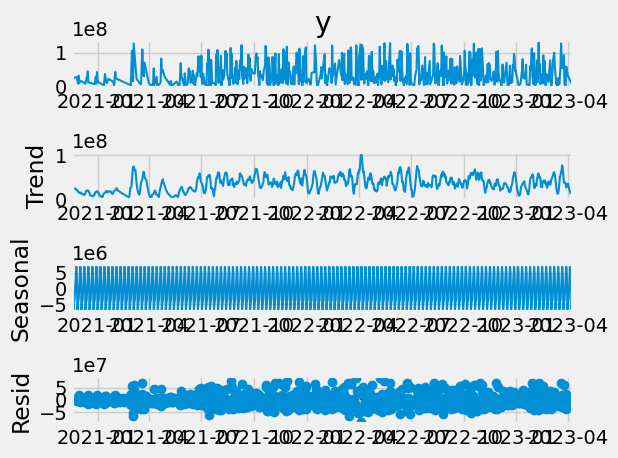

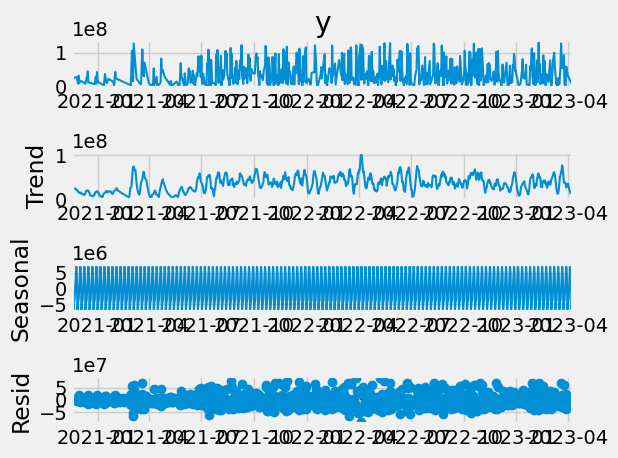

In [5]:
#INTERPOLASI
data = data.asfreq('d')
data = data.interpolate(method='linear')
data = data.fillna(0)
result = seasonal_decompose(data['y'], model = 'additive')
result.plot()

In [6]:
len(data)

873

In [7]:
steps = 28
train = data[:-steps]
test  = data[-steps:]

In [8]:
#MINMAXSCALER
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
scaled_train[:10]

array([[0.1670466 ],
       [0.17301473],
       [0.17898286],
       [0.18495098],
       [0.19091911],
       [0.19688724],
       [0.20285537],
       [0.2088235 ],
       [0.165918  ],
       [0.12301249]])

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
#define generator
n_input = 5 #Give prediction based on 5 month
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)


In [12]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.1670466  0.17301473 0.17898286 0.18495098 0.19091911]
Predict this y: 
 [[0.19688724]]


In [13]:
X.shape

(1, 5, 1)

In [14]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [16]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [18]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
833/833 [==============================] - 8s 7ms/step - loss: 0.0581
Epoch 2/50
833/833 [==============================] - 5s 6ms/step - loss: 0.0560
Epoch 3/50
833/833 [==============================] - 5s 6ms/step - loss: 0.0549
Epoch 4/50
833/833 [==============================] - 9s 11ms/step - loss: 0.0545
Epoch 5/50
833/833 [==============================] - 8s 9ms/step - loss: 0.0542
Epoch 6/50
833/833 [==============================] - 5s 6ms/step - loss: 0.0542
Epoch 7/50
833/833 [==============================] - 6s 7ms/step - loss: 0.0535
Epoch 8/50
833/833 [==============================] - 5s 6ms/step - loss: 0.0538
Epoch 9/50
833/833 [==============================] - 6s 8ms/step - loss: 0.0537
Epoch 10/50
833/833 [==============================] - 6s 7ms/step - loss: 0.0533
Epoch 11/50
833/833 [==============================] - 5s 6ms/step - loss: 0.0533
Epoch 12/50
833/833 [==============================] - 5s 6ms/step - loss: 0.0532
Epoch 13/50
833/833 [===

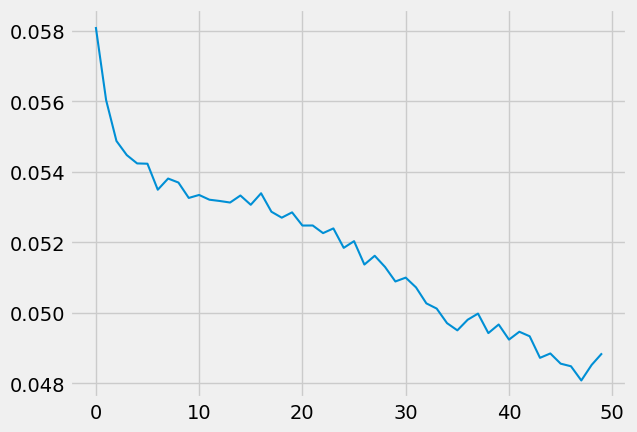

In [19]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [20]:
last_train_batch = scaled_train[-12:]

In [21]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [22]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 442ms/step


array([[0.22698377]], dtype=float32)

In [23]:
scaled_test[0]

array([0.15414737])

In [24]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 33ms/step


In [25]:
test_predictions

[array([0.22698377], dtype=float32),
 array([0.24649341], dtype=float32),
 array([0.2630291], dtype=float32),
 array([0.27840227], dtype=float32),
 array([0.30682647], dtype=float32),
 array([0.33318162], dtype=float32),
 array([0.3634876], dtype=float32),
 array([0.3863895], dtype=float32),
 array([0.38542554], dtype=float32),
 array([0.35422873], dtype=float32),
 array([0.32212335], dtype=float32),
 array([0.29974532], dtype=float32),
 array([0.294662], dtype=float32),
 array([0.3009491], dtype=float32),
 array([0.3164134], dtype=float32),
 array([0.33857507], dtype=float32),
 array([0.36173278], dtype=float32),
 array([0.3759511], dtype=float32),
 array([0.37682253], dtype=float32),
 array([0.3670674], dtype=float32),
 array([0.35068768], dtype=float32),
 array([0.33394924], dtype=float32),
 array([0.3213045], dtype=float32),
 array([0.31577322], dtype=float32),
 array([0.3188933], dtype=float32),
 array([0.3295499], dtype=float32),
 array([0.3448725], dtype=float32),
 array([0.3590

In [26]:
test.head()

,y
ds,
2023-03-13,20201762.0
2023-03-14,628662.0
2023-03-15,23924000.0
2023-03-16,14962000.0
2023-03-17,6000000.0


In [27]:
true_predictions = scaler.inverse_transform(test_predictions)

In [28]:
test['Predictions'] = true_predictions

C:\Users\khali\AppData\Local\Temp\ipykernel_12632\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='ds'>

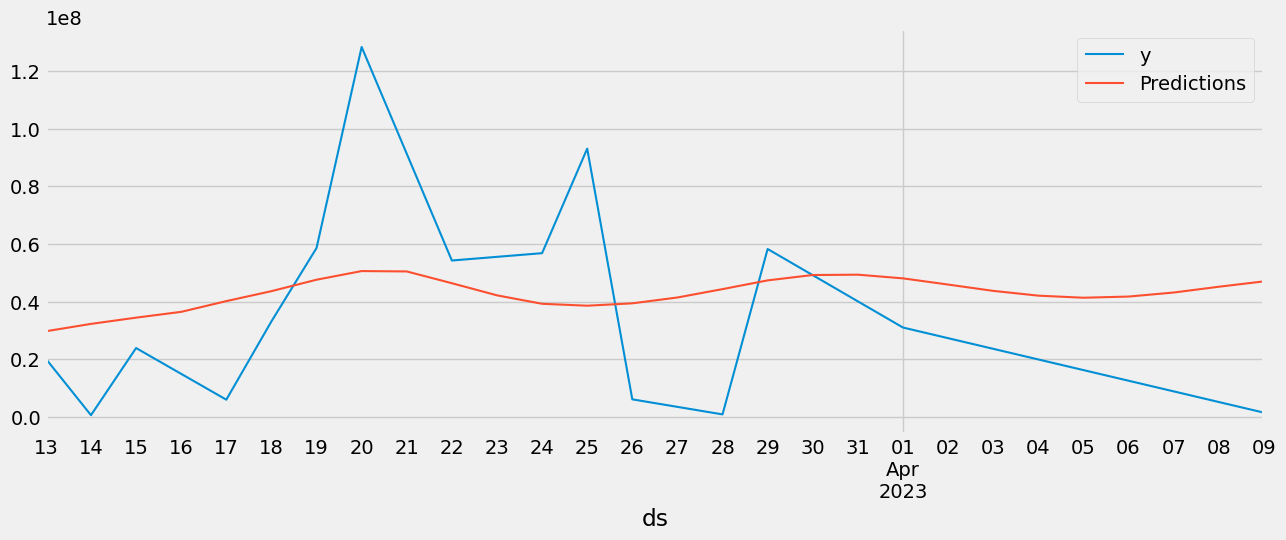

In [29]:
test.plot(figsize=(14,5))

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['y'],test['Predictions']))
print(rmse) 

30940943.25457351
